# This notebook do the binary classification task using SVM and lightGBM models  
Authored by Wen Xie

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import OneHotEncoder

In [2]:
mdata = pd.read_csv('mdata_im.csv')

In [8]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat<0.5,0,1)   # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='weighted'), True

In [9]:
def lgbmodel(params,X_train,lgb_train,lgb_val,early_stop,lgb_f1_score=lgb_f1_score):
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    train_set = lgb_train,
                    num_boost_round=2000,
                    valid_sets = [lgb_train,lgb_val],
                    feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    early_stopping_rounds = early_stop,
                    evals_result=evals_result,
                    feval=lgb_f1_score,
                    verbose_eval=20)
    return gbm, evals_result

## Metadata

### Year

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

In [12]:
enc = OneHotEncoder(handle_unknown='ignore')

In [21]:
X_YR = enc.fit_transform([[i] for i in mdata['Year']]).toarray()
y_YR = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train_YR, X_test_YR, y_train_YR, y_test_YR = train_test_split(X_YR, y_YR, test_size=0.2, random_state=42)
X_train_YR, X_val_YR, y_train_YR, y_val_YR = train_test_split(X_train_YR, y_train_YR, test_size=0.2, random_state=42)
print('X train shape: ', X_train_YR.shape)
print('y train shape: ', y_train_YR.shape)
print('X test shape: ', X_test_YR.shape)
print('y test shape: ', y_test_YR.shape)
print('X val shape: ', X_val_YR.shape)
print('y val shape: ', y_val_YR.shape)

X train shape:  (9724, 102)
y train shape:  (9724,)
X test shape:  (3039, 102)
y test shape:  (3039,)
X val shape:  (2432, 102)
y val shape:  (2432,)


In [22]:
lgb_train_YR = lgb.Dataset(X_train_YR, y_train_YR,free_raw_data=True)
lgb_val_YR = lgb.Dataset(X_val_YR, y_val_YR, reference=lgb_train_YR,free_raw_data=True)

In [23]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}
gbm_YR,_ = lgbmodel(params=params,X_train=X_train_YR,lgb_train=lgb_train_YR,lgb_val=lgb_val_YR,early_stop=20)

In [25]:
y_pred = np.where(gbm_YR.predict(X_test_YR)<0.5,0,1) 
f1_score(y_pred,y_test_YR,average='weighted')

0.611397724734406

### svm

In [28]:
svm_YR = SVC(gamma='scale')
svm_YR.fit(np.r_[X_train_YR,X_val_YR],np.r_[y_train_YR,y_val_YR])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_pred = svm_YR.predict(X_test_YR)
f1_score(y_pred,y_test_YR,average='weighted')

0.6356267616613525

### runtime

In [31]:
import re

In [32]:
mdata['Runtime'].fillna('0 missing',inplace=True)
mdata['Runtime']=mdata['Runtime'].apply(lambda x: ''.join(re.findall('\d',x)))
mdata['Runtime'].fillna(mdata['Runtime'].mean(),inplace=True)

In [33]:
X_RT = enc.fit_transform([[i] for i in mdata['Runtime']]).toarray()
y_RT = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train_RT, X_test_RT, y_train_RT, y_test_RT= train_test_split(X_RT, y_RT, test_size=0.2, random_state=42)
X_train_RT, X_val_RT, y_train_RT, y_val_RT = train_test_split(X_train_RT, y_train_RT, test_size=0.2, random_state=42)
print('X train shape: ', X_train_RT.shape)
print('y train shape: ', y_train_RT.shape)
print('X test shape: ', X_test_RT.shape)
print('y test shape: ', y_test_RT.shape)
print('X val shape: ', X_val_RT.shape)
print('y val shape: ', y_val_RT.shape)

X train shape:  (9724, 222)
y train shape:  (9724,)
X test shape:  (3039, 222)
y test shape:  (3039,)
X val shape:  (2432, 222)
y val shape:  (2432,)


In [34]:
lgb_train_RT = lgb.Dataset(X_train_RT, y_train_RT,free_raw_data=True)
lgb_val_RT = lgb.Dataset(X_val_RT, y_val_RT, reference=lgb_train_RT,free_raw_data=True)
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}
gbm_RT,_ = lgbmodel(params=params,X_train=X_train_RT,lgb_train=lgb_train_RT,lgb_val=lgb_val_RT,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.664677	training's f1: 0.632152	valid_1's binary_logloss: 0.667937	valid_1's f1: 0.636547
[40]	training's binary_logloss: 0.655833	training's f1: 0.636174	valid_1's binary_logloss: 0.658874	valid_1's f1: 0.642155
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.661285	training's f1: 0.634542	valid_1's binary_logloss: 0.664169	valid_1's f1: 0.64227


In [35]:
y_pred = np.where(gbm_RT.predict(X_test_RT)<0.5,0,1) 
f1_score(y_pred,y_test_RT,average='weighted')

0.6320894596612092

### svm

In [37]:
svm_RT = SVC(gamma='scale')
svm_RT.fit(np.r_[X_train_RT,X_val_RT],np.r_[y_train_RT,y_val_RT])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
y_pred = svm_RT.predict(X_test_RT)
f1_score(y_pred,y_test_RT,average='weighted')

0.6291125995378782

### Genre

In [ ]:
mdata['Genre'].fillna('missing',inplace=True)
X_GE = enc.fit_transform([[i] for i in mdata['Genre']]).toarray()
y_GE = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train_GE, X_test_GE, y_train_GE, y_test_GE= train_test_split(X_GE, y_GE, test_size=0.2, random_state=42)
X_train_GE, X_val_GE, y_train_GE, y_val_GE = train_test_split(X_train_GE, y_train_GE, test_size=0.2, random_state=42)
print('X train shape: ', X_train_GE.shape)
print('y train shape: ', y_train_GE.shape)
print('X test shape: ', X_test_GE.shape)
print('y test shape: ', y_test_GE.shape)
print('X val shape: ', X_val_GE.shape)
print('y val shape: ', y_val_GE.shape)

lgb_train_GE = lgb.Dataset(X_train_GE, y_train_GE,free_raw_data=True)
lgb_val_GE = lgb.Dataset(X_val_GE, y_val_GE, reference=lgb_train_GE,free_raw_data=True)

#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}
gbm_GE,_ = lgbmodel(params=params,X_train=X_train_GE,lgb_train=lgb_train_GE,lgb_val=lgb_val_GE,early_stop=20)

In [ ]:
y_pred = np.where(gbm_GE.predict(X_test_GE)<0.5,0,1) 
f1_score(y_pred,y_test_GE,average='weighted')

### svm

In [ ]:
svm_GE = SVC(gamma='scale')
svm_GE.fit(np.r_[X_train_GE,X_val_GE],np.r_[y_train_GE,y_val_GE])
y_pred = svm_GE.predict(X_test_GE)
f1_score(y_pred,y_test_GE,average='weighted')

# 1, NRC-word emotion

In [39]:
emolex = pd.read_csv('fea_emolex.csv')
train_NRC = pd.merge(emolex,mdata,how='right',left_on='ID',right_on='imdbID')

In [40]:
X_NRC = train_NRC.iloc[:,2:52]
y_NRC = le.fit_transform(train_NRC['Binary success'])  #S:1,F:0
X_train_NRC, X_test_NRC, y_train_NRC, y_test_NRC = train_test_split(X_NRC, y_NRC, test_size=0.2, random_state=42)
X_train_NRC, X_val_NRC, y_train_NRC, y_val_NRC = train_test_split(X_train_NRC, y_train_NRC, test_size=0.2, random_state=42)
print('X train shape: ', X_train_NRC.shape)
print('y train shape: ', y_train_NRC.shape)
print('X test shape: ', X_test_NRC.shape)
print('y test shape: ', y_test_NRC.shape)
print('X val shape: ', X_val_NRC.shape)
print('y val shape: ', y_val_NRC.shape)

X train shape:  (9724, 50)
y train shape:  (9724,)
X test shape:  (3039, 50)
y test shape:  (3039,)
X val shape:  (2432, 50)
y val shape:  (2432,)


### Create Dataset object for LightGBM

In [7]:
lgb_train_NRC = lgb.Dataset(X_train_NRC, y_train_NRC,free_raw_data=True)
lgb_val_NRC = lgb.Dataset(X_val_NRC, y_val_NRC, reference=lgb_train_NRC,free_raw_data=True)

In [8]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}

In [9]:
gbm_NRC,_ = lgbmodel(params=params,X_train=X_train_NRC,lgb_train=lgb_train_NRC,lgb_val=lgb_val_NRC,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.643999	training's f1: 0.635092	valid_1's binary_logloss: 0.667511	valid_1's f1: 0.571288
[40]	training's binary_logloss: 0.624449	training's f1: 0.65814	valid_1's binary_logloss: 0.662793	valid_1's f1: 0.588569
[60]	training's binary_logloss: 0.609687	training's f1: 0.672753	valid_1's binary_logloss: 0.662083	valid_1's f1: 0.588152
[80]	training's binary_logloss: 0.595841	training's f1: 0.690971	valid_1's binary_logloss: 0.660797	valid_1's f1: 0.596326
[100]	training's binary_logloss: 0.583015	training's f1: 0.70414	valid_1's binary_logloss: 0.660218	valid_1's f1: 0.598493
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.588936	training's f1: 0.698449	valid_1's binary_logloss: 0.660597	valid_1's f1: 0.600621


### Prediction

In [10]:
y_pred = np.where(gbm_NRC.predict(X_test_NRC)<0.5,0,1) 
f1_score(y_pred,y_test_NRC,average='weighted')

0.6030982154852449

### SVM

In [94]:
from sklearn.svm import SVC
svm_NRC = SVC(gamma='auto')
svm_NRC.fit(np.r_[X_train_NRC,X_val_NRC],np.r_[y_train_NRC,y_val_NRC])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
y_pred = svm_NRC.predict(X_test_NRC)
f1_score(y_pred,y_test_NRC,average='weighted')

0.6844065128813634

In [96]:
y_pred[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [97]:
y_test_NRC[0:20]

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1])

# 2, Poster saliency

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

In [42]:
X_POS = []
for i in mdata['imdbID'].values:
    im = np.array(Image.open('../imsaliency/'+i+'.jpg'))
    X_POS.append(im)

#reshape
X_POS = np.array(X_POS).reshape(len(mdata),-1)

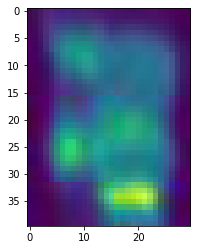

In [43]:
plt.imshow(X_POS[0].reshape(40,30,3))
plt.show()

In [14]:
'''
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X_POS_em = PCA(n_components=1000).fit_transform(X_POS)
'''

'\nfrom sklearn.manifold import TSNE\nfrom sklearn.decomposition import PCA\nX_POS_em = PCA(n_components=1000).fit_transform(X_POS)\n'

In [44]:
y_POS = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train_POS, X_test_POS, y_train_POS, y_test_POS = train_test_split(X_POS, y_POS, test_size=0.2, random_state=42)
X_train_POS, X_val_POS, y_train_POS, y_val_POS = train_test_split(X_train_POS, y_train_POS, test_size=0.2, random_state=42)
print('X train shape: ', X_train_POS.shape)
print('y train shape: ', y_train_POS.shape)
print('X test shape: ', X_test_POS.shape)
print('y test shape: ', y_test_POS.shape)
print('X val shape: ', X_val_POS.shape)
print('y val shape: ', y_val_POS.shape)

X train shape:  (9724, 3600)
y train shape:  (9724,)
X test shape:  (3039, 3600)
y test shape:  (3039,)
X val shape:  (2432, 3600)
y val shape:  (2432,)


In [16]:
lgb_train_POS = lgb.Dataset(X_train_POS, y_train_POS,free_raw_data=True)
lgb_val_POS = lgb.Dataset(X_val_POS, y_val_POS, reference=lgb_train_POS,free_raw_data=True)

In [17]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}

In [18]:
gbm_POS,_ = lgbmodel(params=params,X_train=X_train_POS,lgb_train=lgb_train_POS,lgb_val=lgb_val_POS,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.648739	training's f1: 0.629662	valid_1's binary_logloss: 0.680904	valid_1's f1: 0.52878
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.65676	training's f1: 0.610537	valid_1's binary_logloss: 0.68064	valid_1's f1: 0.533071


### prediction

In [19]:
y_pred = np.where(gbm_POS.predict(X_test_POS)<0.5,0,1) 
f1_score(y_pred,y_test_POS,average='weighted')

0.5927534676519765

### SVM

In [98]:
svm_POS = SVC(gamma='auto')
svm_POS.fit(np.r_[X_train_POS,X_val_POS],np.r_[y_train_POS,y_val_POS])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [99]:
y_pred = svm_POS.predict(X_test_POS)
f1_score(y_pred,y_test_POS,average='weighted')

0.6908544844907242

# 3, Bert sentence embedding

In [45]:
sents_em = np.loadtxt('bert-sents-em15195_200.txt')

In [46]:
y_SEM = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train_SEM, X_test_SEM, y_train_SEM, y_test_SEM = train_test_split(sents_em, y_SEM, test_size=0.2, random_state=42)
X_train_SEM, X_val_SEM, y_train_SEM, y_val_SEM = train_test_split(X_train_SEM, y_train_SEM, test_size=0.2, random_state=42)
print('X train shape: ', X_train_SEM.shape)
print('y train shape: ', y_train_SEM.shape)
print('X test shape: ', X_test_SEM.shape)
print('y test shape: ', y_test_SEM.shape)
print('X val shape: ', X_val_SEM.shape)
print('y val shape: ', y_val_SEM.shape)

X train shape:  (9724, 200)
y train shape:  (9724,)
X test shape:  (3039, 200)
y test shape:  (3039,)
X val shape:  (2432, 200)
y val shape:  (2432,)


In [66]:
lgb_train_SEM = lgb.Dataset(X_train_SEM, y_train_SEM,free_raw_data=False)
lgb_val_SEM = lgb.Dataset(X_val_SEM, y_val_SEM, reference=lgb_train_SEM,free_raw_data=False)

In [67]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}

In [68]:
gbm_SEM,_ = lgbmodel(params=params,X_train=X_train_SEM,lgb_train=lgb_train_SEM,lgb_val=lgb_val_SEM,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.655378	training's f1: 0.620958	valid_1's binary_logloss: 0.680791	valid_1's f1: 0.530354
[40]	training's binary_logloss: 0.628197	training's f1: 0.690409	valid_1's binary_logloss: 0.673323	valid_1's f1: 0.562875
[60]	training's binary_logloss: 0.605051	training's f1: 0.733387	valid_1's binary_logloss: 0.670492	valid_1's f1: 0.58053
[80]	training's binary_logloss: 0.583396	training's f1: 0.773723	valid_1's binary_logloss: 0.668523	valid_1's f1: 0.585024
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.588695	training's f1: 0.764408	valid_1's binary_logloss: 0.668314	valid_1's f1: 0.583817


### prediction

In [69]:
y_pred = np.where(gbm_SEM.predict(X_test_SEM)<0.5,0,1) 
f1_score(y_pred,y_test_SEM,average='weighted')

0.5960491784840407

### SVM

In [102]:
svm_SEM = SVC(gamma='auto')

In [103]:
svm_SEM.fit(np.r_[X_train_SEM,X_val_SEM],np.r_[y_train_SEM,y_val_SEM])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
y_pred = svm_SEM.predict(X_test_SEM)
f1_score(y_pred,y_test_SEM,average='weighted')

0.6144448068392628

## 4, Writing style

In [47]:
ws = pd.read_csv('fea_writing.csv')

In [48]:
train_ws = pd.merge(ws,mdata,how='right',left_on='imdbID',right_on='imdbID')

In [33]:
train_ws.columns

Index(['#word', '#char', '#uppe', '#titl', '#exlc', '#ques', 'av_l_wor',
       'av_l_sen', 'av_wor_p_sen', 'lex_div', 'imdbID', 'Plot', 'Title',
       'Ratings', 'DVD', 'Production', 'Actors', 'Type', 'imdbVotes',
       'Website', 'Poster', 'Director', 'Released', 'Awards', 'Genre',
       'imdbRating', 'Language', 'Country', 'BoxOffice', 'Runtime',
       'Metascore', 'Response', 'Year', 'Multi-class success',
       'Binary success', 'name', 'file'],
      dtype='object')

In [49]:
X_WS = train_ws.iloc[:,0:10]
y_WS  = le.fit_transform(train_ws['Binary success'])  #S:1,F:0
X_train_WS , X_test_WS , y_train_WS , y_test_WS  = train_test_split(X_WS , y_WS , test_size=0.2, random_state=42)
X_train_WS , X_val_WS , y_train_WS , y_val_WS  = train_test_split(X_train_WS , y_train_WS , test_size=0.2, random_state=42)
print('X train shape: ', X_train_WS.shape)
print('y train shape: ', y_train_WS.shape)
print('X test shape: ', X_test_WS.shape)
print('y test shape: ', y_test_WS.shape)
print('X val shape: ', X_val_WS.shape)
print('y val shape: ', y_val_WS.shape)

X train shape:  (9724, 10)
y train shape:  (9724,)
X test shape:  (3039, 10)
y test shape:  (3039,)
X val shape:  (2432, 10)
y val shape:  (2432,)


In [35]:
lgb_train_WS = lgb.Dataset(X_train_WS, y_train_WS,free_raw_data=True)
lgb_val_WS= lgb.Dataset(X_val_WS, y_val_WS, reference=lgb_train_WS,free_raw_data=True)

In [36]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}

In [37]:
gbm_WS,_ = lgbmodel(params=params,X_train=X_train_WS,lgb_train=lgb_train_WS,lgb_val=lgb_val_WS,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.677839	training's f1: 0.488036	valid_1's binary_logloss: 0.693386	valid_1's f1: 0.423896
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.689661	training's f1: 0.371826	valid_1's binary_logloss: 0.689948	valid_1's f1: 0.379044


### prediction

In [38]:
y_pred = np.where(gbm_WS.predict(X_test_WS)<0.5,0,1) 
f1_score(y_pred,y_test_WS,average='weighted')

0.6909325866896403

### svm

In [106]:
svm_WS = SVC(gamma='auto')

In [107]:
svm_WS.fit(np.r_[X_train_WS,X_val_WS],np.r_[y_train_WS,y_val_WS])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [108]:
y_pred = svm_WS.predict(X_test_WS)
f1_score(y_pred,y_test_WS,average='weighted')

0.6898369586342017

## All feature together

In [50]:
X = np.c_[train_NRC.iloc[:,2:52],X_POS,sents_em,train_ws.iloc[:,0:10],X_YR,X_RT]

In [51]:
y  = le.fit_transform(mdata['Binary success'])  #S:1,F:0
X_train , X_test , y_train , y_test  = train_test_split(X, y, test_size=0.2, random_state=42)
X_train , X_val , y_train , y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)
print('X val shape: ', X_val.shape)
print('y val shape: ', y_val.shape)

X train shape:  (9724, 4184)
y train shape:  (9724,)
X test shape:  (3039, 4184)
y test shape:  (3039,)
X val shape:  (2432, 4184)
y val shape:  (2432,)


In [111]:
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_val= lgb.Dataset(X_val, y_val, reference=lgb_train,free_raw_data=False)

In [114]:
#params = {'num_leaves': 5,'metric': ['cross_entropy'],'verbose': -1}
params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'num_leaves': 10,
          'learning_rate':0.1,
          'verbose': -1}

In [115]:
gbm,_ = lgbmodel(params=params,X_train=X_train,lgb_train=lgb_train,lgb_val=lgb_val,early_stop=20)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.644274	training's f1: 0.648535	valid_1's binary_logloss: 0.676134	valid_1's f1: 0.557712
[40]	training's binary_logloss: 0.612698	training's f1: 0.706798	valid_1's binary_logloss: 0.673656	valid_1's f1: 0.568803
[60]	training's binary_logloss: 0.58572	training's f1: 0.750644	valid_1's binary_logloss: 0.672873	valid_1's f1: 0.579386
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.601462	training's f1: 0.723223	valid_1's binary_logloss: 0.672519	valid_1's f1: 0.577461


### prediction

In [116]:
y_pred = np.where(gbm.predict(X_test)<0.5,0,1) 
f1_score(y_pred,y_test,average='weighted')

0.5941972465385874

### svm

In [117]:
svm = SVC(gamma='auto')
svm.fit(np.r_[X_train,X_val],np.r_[y_train,y_val])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [118]:
y_pred = svm.predict(X_test)
f1_score(y_pred,y_test,average='weighted')

0.6909325866896403

## Finetuning

In [55]:
from sklearn.model_selection import GridSearchCV

### lightgbm finetune

### svm finetune

In [ ]:
aram_grid = {'C': [0.1,10,1000],  
              'gamma': [1,1e-5,1e-10], 
              'kernel': ['rbf']}  
grid = GridSearchCV(SVC(), param_grid, scoring='f1_weighted', cv=3, refit=True, verbose=3) 
# fitting the model for grid search 
grid.fit(np.r_[X_train,X_val], np.r_[y_train,y_val]) 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.373, total= 9.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.373, total= 9.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 18.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.373, total= 9.0min
[CV] C=0.1, gamma=1e-05, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-05, kernel=rbf, score=0.373, total= 8.4min
[CV] C=0.1, gamma=1e-05, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-05, kernel=rbf, score=0.373, total= 8.7min
[CV] C=0.1, gamma=1e-05, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-05, kernel=rbf, score=0.373, total= 8.8min
[CV] C=0.1, gamma=1e-10, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-10, kernel=rbf, score=0.373, total= 7.6min
[CV] C=0.1, gamma=1e-10, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-10, kernel=rbf, score=0.373, total= 7.5min
[CV] C=0.1, gamma=1e-10, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=1e-10, kernel=rbf, score=0.373, total= 8.2min
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

### Plot metrics recorded during training

In [ ]:
try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
import matplotlib.pyplot as plt

In [ ]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

In [ ]:
if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=params['metric'])
else:
    render_metric(params['metric'][0])

### Plot feature importances

In [ ]:
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=3):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

In [ ]:
if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, X_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

### Plot split value histogram

In [ ]:
def render_histogram(feature):
    ax = lgb.plot_split_value_histogram(gbm, feature=feature,
                                        bins='auto', figsize=(10, 5))
    plt.show()

In [ ]:
if INTERACTIVE:
    # create widget for interactive split value histogram
    interact(render_histogram,
             feature=gbm.feature_name())
else:
    render_histogram(feature='f26')